下面将使用预训练好的 VGG16 来训练猫和狗的分类网络。

In [2]:
import tensorflow as tf
from keras import models
from keras import layers
from keras.applications import VGG16

In [3]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

2023-10-01 17:08:50.205921: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-01 17:08:50.205945: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-01 17:08:50.205952: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-01 17:08:50.206107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-01 17:08:50.206127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


在编译模型之前，非常重要的一步是 **冻结卷积网络的参数**。因为我们是使用预训练好的卷积网络，然后再在其最后添加用于分类的全连接层。如果不冻结，那么在训练的时候，很有可能分类网络的变动会通过反向传播破坏卷积网络的预训练参数。所以正确的做法应该先冻结卷积网络，训练，然后再解冻，再训练。

In [4]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


In [5]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train'
validation_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/validation'
test_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# !!! The validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/150


2023-10-01 17:09:37.695465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 11s 107ms/step - loss: 0.6014 - accuracy: 0.6725 - val_loss: 0.4895 - val_accuracy: 0.7770
Epoch 2/150
100/100 [==============================] - 10s 99ms/step - loss: 0.4815 - accuracy: 0.7845 - val_loss: 0.3858 - val_accuracy: 0.8440
Epoch 3/150
100/100 [==============================] - 10s 100ms/step - loss: 0.4348 - accuracy: 0.8015 - val_loss: 0.3407 - val_accuracy: 0.8680
Epoch 4/150
100/100 [==============================] - 10s 103ms/step - loss: 0.4078 - accuracy: 0.8210 - val_loss: 0.3248 - val_accuracy: 0.8640
Epoch 5/150
100/100 [==============================] - 10s 101ms/step - loss: 0.3794 - accuracy: 0.8325 - val_loss: 0.3086 - val_accuracy: 0.8700
Epoch 6/150
100/100 [==============================] - 10s 97ms/step - loss: 0.3584 - accuracy: 0.8445 - val_loss: 0.2868 - val_accuracy: 0.8870
Epoch 7/150
100/100 [==============================] - 10s 102ms/step - loss: 0.3652 - accuracy: 0.8425 - val_loss: 0.2927 - val_accuracy:

In [12]:
model.save('/Users/bifnudozhao/Projects/ai-playground/results/cats_and_dogs_small_3.keras')

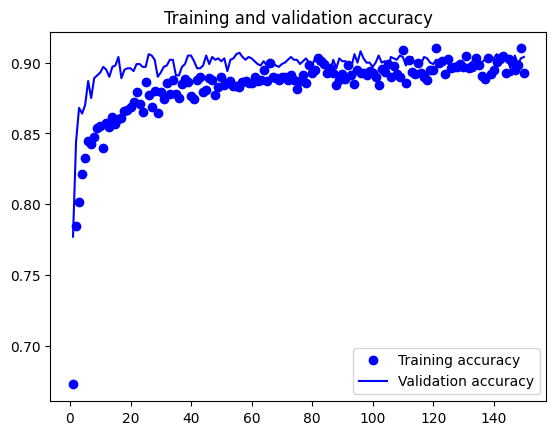

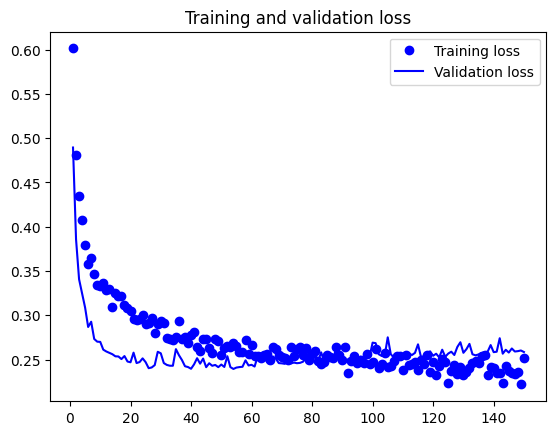

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [16]:
ft_history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/150
100/100 [==============================] - 13s 115ms/step - loss: 0.3293 - accuracy: 0.8660 - val_loss: 0.3952 - val_accuracy: 0.8630
Epoch 2/150
100/100 [==============================] - 11s 114ms/step - loss: 0.2694 - accuracy: 0.8865 - val_loss: 0.2539 - val_accuracy: 0.9060
Epoch 3/150
100/100 [==============================] - 11s 113ms/step - loss: 0.2480 - accuracy: 0.9015 - val_loss: 0.2503 - val_accuracy: 0.9080
Epoch 4/150
100/100 [==============================] - 11s 114ms/step - loss: 0.2213 - accuracy: 0.9135 - val_loss: 0.2526 - val_accuracy: 0.9120
Epoch 5/150
100/100 [==============================] - 11s 113ms/step - loss: 0.1984 - accuracy: 0.9210 - val_loss: 0.2527 - val_accuracy: 0.9180
Epoch 6/150
100/100 [==============================] - 12s 118ms/step - loss: 0.1754 - accuracy: 0.9340 - val_loss: 0.2989 - val_accuracy: 0.9080
Epoch 7/150
100/100 [==============================] - 12s 116ms/step - loss: 0.1768 - accuracy: 0.9355 - val_loss: 0.2226 -

In [18]:
model.save('/Users/bifnudozhao/Projects/ai-playground/results/cats_and_dogs_small_ft.keras')

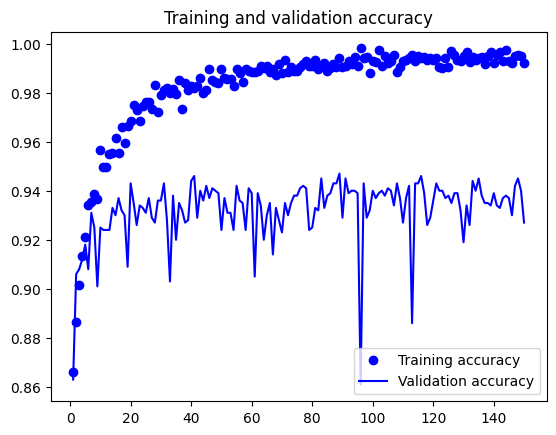

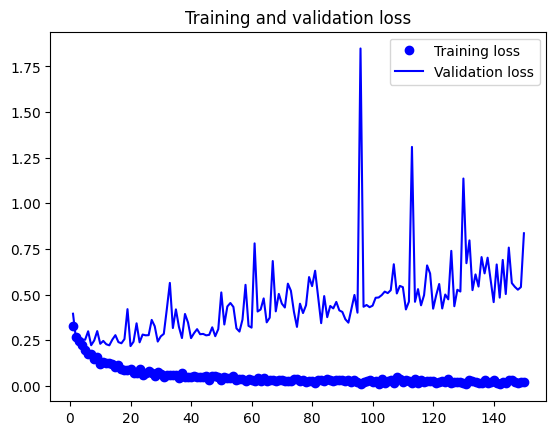

In [17]:
acc = ft_history.history['accuracy']
val_acc = ft_history.history['val_accuracy']
loss = ft_history.history['loss']
val_loss = ft_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


50/50 [==============================] - 3s 64ms/step - loss: 1.0488 - accuracy: 0.9300
test acc: 0.9300000071525574
